In [1]:
import pandas as pd
import os

def get_dataframe(dataset_path, encoding="utf-8"):
    try:
        # List all files in the dataset directory
        files = os.listdir(dataset_path)

        # Dictionary to store DataFrames
        dataframes = {}

        # Loop through each file
        for file in files:
            file_path = os.path.join(dataset_path, file)

            # Check for .csv or .txt files
            if file.endswith(".csv"):
                data = pd.read_csv(file_path, engine='c', encoding=encoding)
                dataframes[file] = data
            elif file.endswith(".txt"):
                data = pd.read_csv(file_path, delimiter='[|\t]', engine='python', header=None, encoding=encoding)
                dataframes[file] = data
        return dataframes
    except FileNotFoundError as e:
        print(f"Error: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

In [2]:
kmrd_path = "../../kmrd-small"
dataframes = get_dataframe(kmrd_path)
print(f"{dataframes.keys()}")

dict_keys(['countries.csv', 'movies.txt', 'genres.csv', 'rates.csv', 'peoples.txt', 'castings.csv'])


In [3]:
# countries.csv 데이터프레임 불러오기
countries_df = dataframes['countries.csv']

movies_df = dataframes['movies.txt'].copy()
movies_df.columns = movies_df.iloc[0]  # 첫 번째 행을 열 이름으로 설정
movies_df = movies_df.iloc[1:]  # 첫 번째 행 제거
movies_df.reset_index(drop=True, inplace=True)

# 1. Title과 Title_eng의 결측치를 처리
# 둘 중 하나만 있는 경우, 없는 값을 다른 값으로 채움
movies_df.loc[movies_df['title'].isnull() & movies_df['title_eng'].notnull(), 'title'] = movies_df['title_eng']
movies_df.loc[movies_df['title_eng'].isnull() & movies_df['title'].notnull(), 'title_eng'] = movies_df['title']

# 둘 다 없는 경우 해당 행 제거
movies_df = movies_df.dropna(subset=['title', 'title_eng'])


# 2. Year 열의 결측치를 최빈값으로 채움
if movies_df['year'].isnull().sum() > 0:  # 결측치가 있는 경우
    most_frequent_year = movies_df['year'].mode()[0]  # 최빈값 계산
    movies_df['year'] = movies_df['year'].fillna(most_frequent_year)

# 3. Grade 열의 결측치를 'Unknown'으로 채움
movies_df['grade'] = movies_df['grade'].fillna('Unknown')

# 4. type 재설정
movies_df['movie'] = movies_df['movie'].astype(int)
movies_df['year'] = movies_df['year'].astype(int)

genres_df = dataframes['genres.csv']
rates_df = dataframes['rates.csv']

# Unix 타임스탬프를 datetime으로 변환
rates_df['time'] = pd.to_datetime(rates_df['time'], unit='s')

# peoples.txt 데이터프레임 불러오기
peoples_df = dataframes['peoples.txt'].copy()

# 첫 번째 행 제거 및 열 이름 설정
peoples_df.columns = peoples_df.iloc[0]  # 첫 번째 행을 열 이름으로 설정
peoples_df = peoples_df.iloc[1:]  # 첫 번째 행 제거

# 인덱스 재설정
peoples_df.reset_index(drop=True, inplace=True)

peoples_df['original'] = peoples_df['original'].fillna('Unknown')

# 4. type 재설정
peoples_df['people'] = peoples_df['people'].astype(int)

# castings.csv 데이터프레임 불러오기
castings_df = dataframes['castings.csv']

In [4]:
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # MacOS: 'AppleGothic', Windows: 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

## 사용자 탐색
- 사용자별로 몇 편의 영화에 평점을 부여했는지 분포를 확인하라(histogram)
- 사용자의 활동 패턴(예: 활동 기간, 평점 주기 패턴)을 탐색하라. (Line chart)
- 사용자의 선호 장르를 파악할 수 있게 시각화하라. (Heatmap)

### histogram

In [5]:
import seaborn as sns

def draw_histogram(df, column_name, bins=10, figsize=(7, 4), title=None, xlabel=None, ylabel=None):
    """
    Draw a histogram for grouped data.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        column_name (str): The name of the column to plot.
        bins (int): Number of bins for the histogram. Default is 10.
        figsize (tuple): Size of the figure. Default is (7, 4).
        title (str): Title for the histogram. Default is None.
    """
    plt.figure(figsize=figsize)
    sns.histplot(data=df, x=column_name, bins=bins, kde=False, color="skyblue")
    plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title if title else f'Histogram of {column_name}', fontsize=14)
    plt.tight_layout()
    plt.show()

### 사용자의 평점 별 영화 수

In [6]:
rates_df.head(3)

,user,movie,rate,time
0,0,10003,7,2017-05-07 03:34:00
1,0,10004,7,2016-07-03 07:10:00
2,0,10018,9,2017-12-15 13:22:00


In [7]:
def group_movie_counts(movie_count_df):
    bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, float('inf')]  # 구간 설정
    labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9+']  # 라벨 설정
    movie_count_df['movie_count_group'] = pd.cut(
        movie_count_df['movie_count'], bins=bins, labels=labels, right=False
    )
    return movie_count_df

pd.cut: Pandas에서 데이터를 구간(bin)으로 나누어 범주형(Categorical) 데이터를 생성하는 함수
- right: 구간의 끝이 포함되는지 여부 (True이면 오른쪽 경계값 포함)
- include_lowest: 가장 낮은 값을 포함할지 여부 (True이면 포함

[1, 2) → '1'  
[2, 3) → '2'  
[3, 4) → '3'  
...  
[9, ∞) → '9+'  

In [110]:
grouped_movie_count = (
    rates_df.groupby('user', as_index=False)
    .agg(movie_count=('movie', 'count'))  # 사용자별 영화 평가 수 계산
    .pipe(group_movie_counts)  # group_movie_counts 함수 호출
)
# print(grouped_movie_count) 

print(grouped_movie_count.sort_values(by='movie_count', ascending=False)[grouped_movie_count['movie_count'] < 10].reset_index())

       index   user  movie_count movie_count_group
0       7450   7450            9                9+
1      11905  11905            9                9+
2      11028  11028            9                9+
3       3320   3320            9                9+
4       3191   3191            9                9+
...      ...    ...          ...               ...
49882  24793  24793            1                 1
49883  24794  24794            1                 1
49884  24796  24796            1                 1
49885  24797  24797            1                 1
49886  52027  52027            1                 1

[49887 rows x 4 columns]


/var/folders/yf/smmqndn14hg9ztt178vb33t40000gn/T/ipykernel_23399/45200272.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(grouped_movie_count.sort_values(by='movie_count', ascending=False)[grouped_movie_count['movie_count'] < 10].reset_index())



- assign : 새로운 열(month)을 추가하면서 원래의 rates_df를 유지. 함수 내부에서 새로운 열을 추가할 때 assign을 사용해 불필요한 복사를 방지.
- groupby에서 as_index=False를 지정해 결과를 열 형태로 반환.
- pipe를 사용하면 함수를 직접 호출하지 않고 체인에 포함.

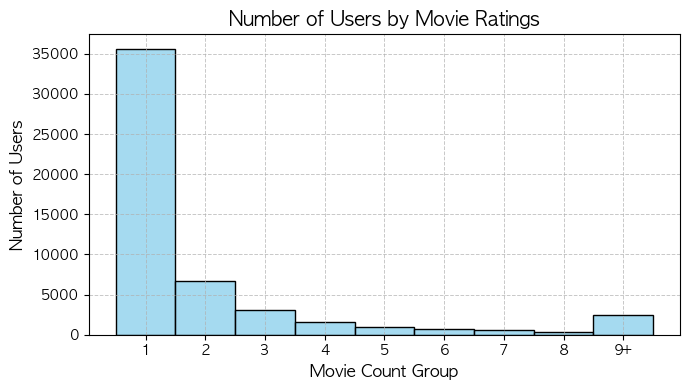

In [9]:
draw_histogram(
    grouped_movie_count,
    column_name='movie_count_group',
    bins = grouped_movie_count['movie_count_group'].unique(),
    title='Number of Users by Movie Ratings',
    xlabel='Movie Count Group',
    ylabel='Number of Users',
)

### Line Chart

In [10]:
import matplotlib.pyplot as plt

def draw_line_chart(df, x_column, y_column, figsize=(7, 4), title=None, xlabel=None, ylabel=None):
    """
    Draw a line chart for the given columns in a DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        x_column (str): The name of the column for the x-axis.
        y_column (str): The name of the column for the y-axis.
        figsize (tuple): Size of the figure. Default is (7, 4).
        title (str): Title for the line chart. Default is None.
        xlabel (str): Label for the x-axis. Default is None.
        ylabel (str): Label for the y-axis. Default is None.
        linestyle (str): Line style for the plot. Default is '-'.
        marker (str): Marker style for the plot. Default is 'o'.
    """
    plt.figure(figsize=figsize)
    plt.plot(df[x_column], df[y_column], linestyle='-', color='skyblue')
    plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
    plt.xlabel(xlabel if xlabel else x_column, fontsize=12)
    plt.ylabel(ylabel if ylabel else y_column, fontsize=12)
    plt.title(title if title else f'Line Chart of {x_column} per {y_column}', fontsize=14)
    plt.tight_layout()
    plt.show()


### 사용자의 활동 패턴

In [11]:
rates_activity = rates_df.assign(
    month=rates_df['time'].dt.to_period('M').dt.to_timestamp()
).groupby('month', as_index=False).agg(
    mean_rate=('rate', 'mean')
)

print(rates_activity)

         month  mean_rate
0   2003-11-01   9.068966
1   2003-12-01   9.009346
2   2004-01-01   9.360825
3   2004-02-01   9.030928
4   2004-03-01   9.101695
..         ...        ...
189 2019-08-01   8.759082
190 2019-09-01   8.916388
191 2019-10-01   9.069767
192 2019-11-01   9.072289
193 2019-12-01   9.069686

[194 rows x 2 columns]


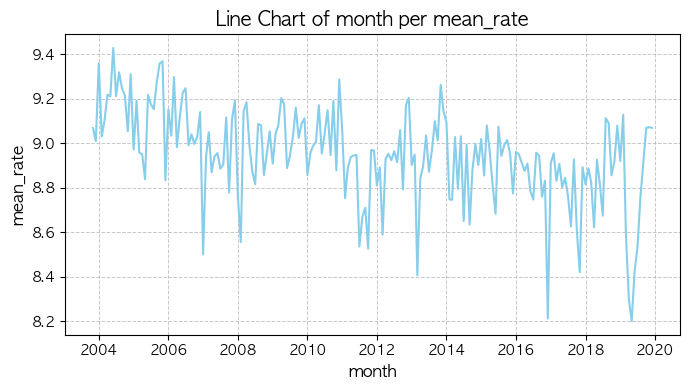

In [12]:
draw_line_chart(rates_activity, 'month', 'mean_rate')

In [91]:
# 특정 사용자 ID 설정
user_id = 0

user_activity = rates_df.loc[rates_df['user'] == user_id].assign(
    month=rates_df['time'].dt.to_period('M').dt.to_timestamp()
).groupby('month', as_index=False).agg(
    mean_rate=('rate', 'mean')
)

user_activity.head(3)

,month,mean_rate
0,2014-01-01,10.0
1,2014-03-01,8.5
2,2014-06-01,9.0


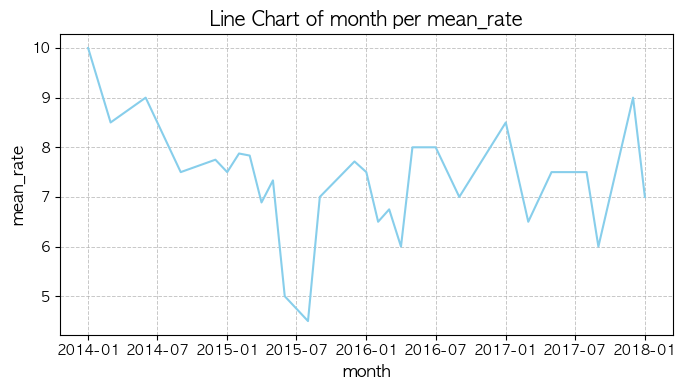

In [92]:
draw_line_chart(user_activity, 'month', 'mean_rate')

### Heatmap

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

def draw_heatmap(df, x_column, y_column, value_column, figsize=(7, 7), title=None, xlabel=None, ylabel=None):
    """
    Draw a heatmap for the given columns in a DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        x_column (str): The name of the column for the x-axis.
        y_column (str): The name of the column for the y-axis.
        value_column (str): The name of the column for the heatmap values.
        figsize (tuple): Size of the figure. Default is (7, 4).
        title (str): Title for the heatmap. Default is None.
        xlabel (str): Label for the x-axis. Default is None.
        ylabel (str): Label for the y-axis. Default is None.
        cmap (str): Colormap for the heatmap. Default is 'Blues'.
    """
    plt.figure(figsize=figsize)
    
    # 피벗 테이블 생성 (x_column, y_column으로 행렬 생성)
    pivot_table = df.pivot(index=y_column, columns=x_column, values=value_column).fillna(0)
    
    # 히트맵 생성
    sns.heatmap(pivot_table, annot=False, fmt=".2f", cbar=True)
    
    # 축 및 제목 설정
    plt.xlabel(xlabel if xlabel else x_column, fontsize=12)
    plt.ylabel(ylabel if ylabel else y_column, fontsize=12)
    plt.title(title if title else f'Heatmap of {value_column}', fontsize=14)
    plt.tight_layout()
    plt.show()


### 사용자의 선호 장르

In [94]:
rates_df.head(3)

,user,movie,rate,time
0,0,10003,7,2017-05-07 03:34:00
1,0,10004,7,2016-07-03 07:10:00
2,0,10018,9,2017-12-15 13:22:00


In [95]:
genres_df.head(3)

,movie,genre
0,10001,드라마
1,10001,멜로/로맨스
2,10002,SF


In [96]:
user_genre_df = rates_df[rates_df['user']<= 20].merge(
    genres_df, on='movie'
).groupby(['user', 'genre'], as_index=False).agg(
    mean_rate=('rate', 'mean')
)

# 결과 출력
print(user_genre_df)

     user  genre  mean_rate
0       0     SF   7.818182
1       0     가족   7.333333
2       0     공포   9.000000
3       0    느와르   8.500000
4       0    드라마   7.266667
..    ...    ...        ...
189    20  애니메이션   7.000000
190    20     액션   7.047619
191    20     전쟁   7.647059
192    20    코미디   7.217391
193    20    판타지   7.000000

[194 rows x 3 columns]


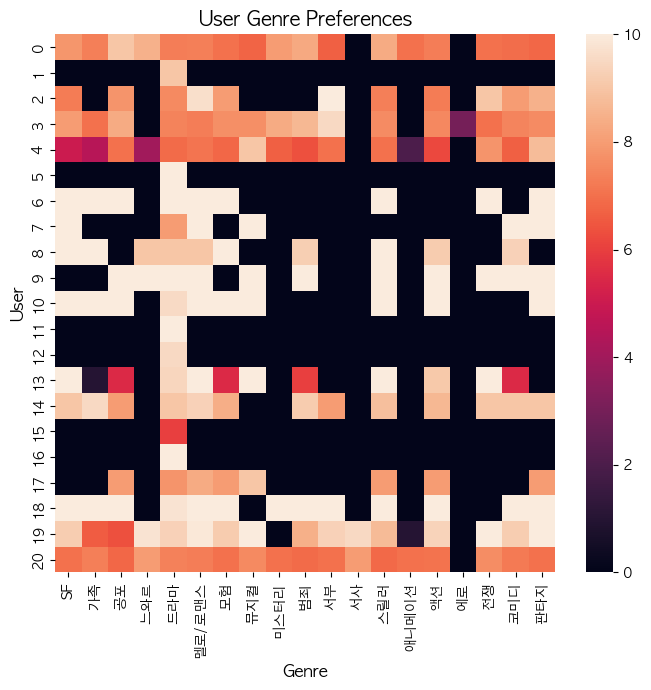

In [97]:
draw_heatmap(
    df=user_genre_df,
    x_column='genre',
    y_column='user',
    value_column='mean_rate',
    title='User Genre Preferences',
    xlabel='Genre',
    ylabel='User',
)